<a href="https://colab.research.google.com/github/Saatvik-Aggarwal/phased-array/blob/main/Beamforming_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi
from scipy import signal
from matplotlib import cm

## Math for 2D Complex Exponential Method

The equation in 2 dimensions, $u$ and $v$, becomes

\begin{equation}
    \Large F(\theta, \phi) = \sum_{m}^{M} \sum_{n}^{N} \lvert a_{m,n} \rvert \exp{\left\{ j k_0 \left[ m d_x (u - u_0) + n d_y (v - v_0) \right] \right\}}
\end{equation}

or if $a_{m,n}$ is separable to $a_{m,n} = b_m c_n$, then


\begin{equation}
    \Large F(\theta, \phi) = \left\{ \sum b_m \exp{\left[ j k_0  m d_x \left( u - u_0 \right) \right]} \right\}
        \left\{ \sum c_n \exp{\left[ j k_0  n d_y \left( v - v_0 \right) \right]} \right\}
\end{equation}

# **Section 1**: Steady-state Antenna Radiation Model

Worklfow for 4x4 Beamforming Algorithm

1. Define Array Parameters
2. Build UV Direction-Cosine Grid
3. Apply Steering Vector
4. Compute Array Factor
5. Normlize, Mask and Plot


*optional add

6. Taylor Amplitude Tapering (Replace uniform weights with Taylor window coefficients to suppress sidelobes while maintaining main-lobe width.)

In [ ]:
# Setup of constants

carrier_frequency = 10e9  # RF Center frequency (Hz)
lam = c / carrier_frequency  # Wavelength (m)
k = 2 * pi / lam  # wave number


# Define Array Layout
# Uniform Rectangular Array with half-wavelength spacing

d_x = d_y = lam / 2  # element spacing (m) // to avoid grating lobes for moderate scan
N , M = 4 , 4  # ULA 4x4

n = np.arange(N)  # array for summing over n
m = np.arange(M)  # array for summing over m

In [ ]:
# Choose Steering Angles (Beam Direction)

elevation_steering_angle = 0  # theta steering angle |up-down (0 = straight ahead)
azimuth_steering_angle = 0  # phi steering angle | left-right

# Convert to sine space

u_0 = np.sin(np.deg2rad(elevation_steering_angle))
v_0 = np.sin(np.deg2rad(azimuth_steering_angle))

In [ ]:
# Spatial Sampling Grid in Direction-Cosine Space (UV plane)
# Normalized Radiation Pattern
# --- Creating the map of directions that the algorithm will sweep over

points = 250 # Resolution

# Angle Arrays

theta = np.linspace(-pi, pi, points)
phi = np.linspace(-pi, pi, points)

# 1D arrays of direction-cosine values

u = np.linspace(-1, 1, points)
v = np.linspace(-1, 1, points)

# 2D mesh grid of sine space (U[i,j], V[i,j])

U, V = np.meshgrid(u, v)
mask = (U**2 + V**2) <= 1

In [ ]:
# Weighted Summation or Array Factor (2D) with Steering Vector Term
# Complex steering weights and AF Summation
# --- Function already shifts their phases so that beam point is in desired diection


def compute_af_steering(U, V, weight_n, weight_m, d_x, d_y, k, u_0, v_0, M, N):

  # sum over n columns
  n = np.arange(N)[:, None, None]
  AF_n = np.sum(
      weight_n[:, None, None] * np.exp(1j * n * d_x * k * (U - u_0)),
      axis=0,
  )
  # sum over m columns
  m = np.arange(M)[:, None, None]
  AF_m = np.sum(
      weight_m[:, None, None] * np.exp(1j * m * d_y * k * (V - v_0)),
      axis=0,
  )

  return AF_m * AF_n / (M * N)

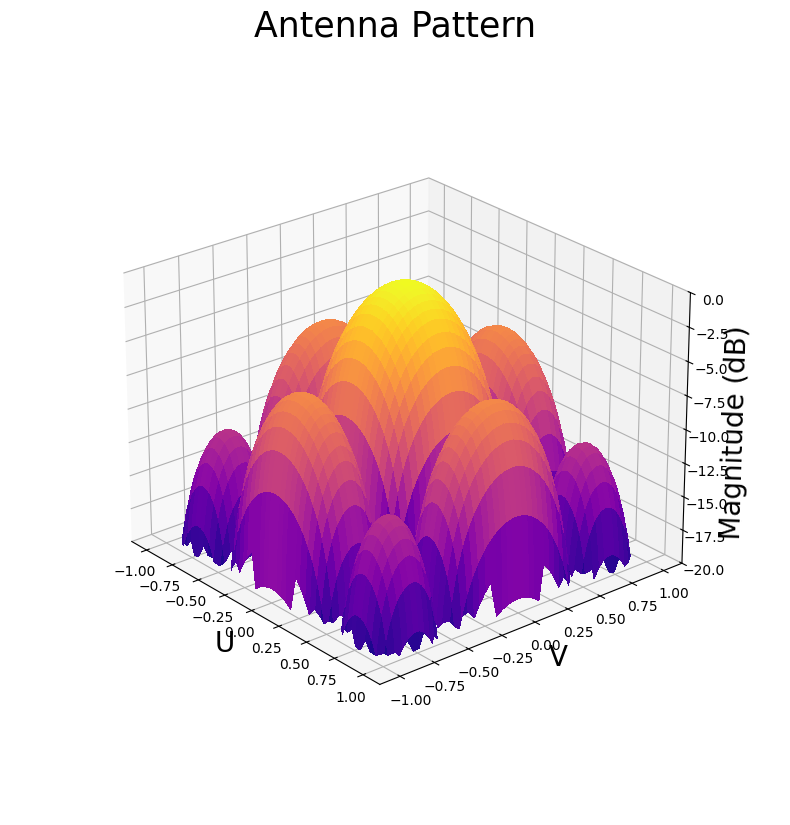

In [ ]:
%matplotlib inline


# Min and Max dB level to display
db_min = -20
db_max = 0

# Uniform weighting (every antenna element radiates with equal amplitude)
weight_n = np.ones(N)
weight_m = np.ones(M)
AF_pattern = compute_af_steering(U, V, weight_n, weight_m, d_x, d_y, k, u_0, v_0, M, N)

# Normalize and convert to dB
AF_pattern_log = 10 * np.log10(np.abs(AF_pattern)) # Patern Normalization & dB Scaling
AF_pattern_log_mask = np.where(AF_pattern_log > db_min, AF_pattern_log, np.nan)


# Pattern Plotting / Beam Visualization in 3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = "3d")
ax.plot_surface(U, V, AF_pattern_log_mask, cmap = 'plasma', antialiased = False)
ax.set_zlim(db_min, db_max)

ax.set_title("Antenna Pattern", fontsize = 25)
ax.set_zlabel("Magnitude (dB)", fontsize = 20); ax.set_xlabel("U", fontsize = 20); ax.set_ylabel("V", fontsize = 20)

ax.set_box_aspect(None, zoom = 0.80)
ax.view_init(elev = 25, azim = -40, roll = 0)
plt.show()

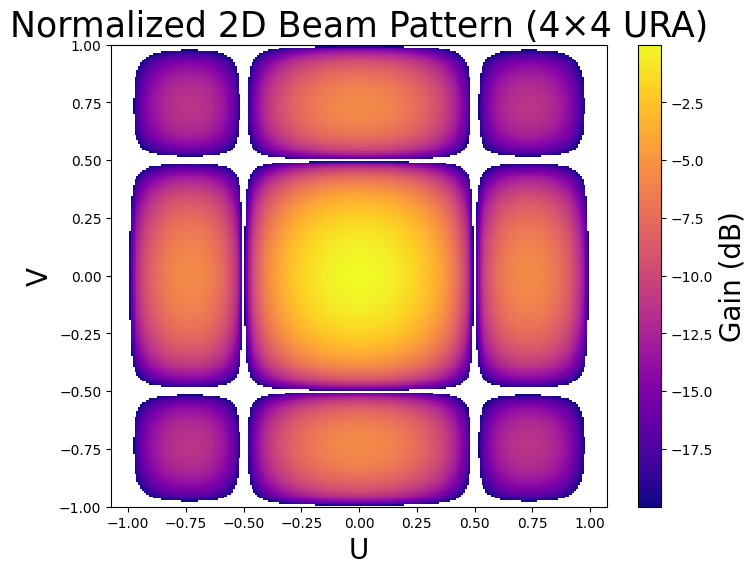

In [ ]:
# 2D Heatmap

plt.figure(figsize=(8, 6))
im = plt.pcolormesh(U, V, AF_pattern_log_mask, shading='auto', cmap='plasma')
cbar = plt.colorbar(im)
cbar.set_label('Gain (dB)', fontsize = 20)
plt.title('Normalized 2D Beam Pattern (4×4 URA)', fontsize = 25)
plt.xlabel('U', fontsize = 20); plt.ylabel('V', fontsize = 20)
plt.axis('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

In [ ]:
# Creating a Taylor weighting window
# --- Instead of every element radiation equally, this window smoothly lowers the amplitude
#       toward the edges of the array to reduce sidelobes in the radiation pattern


# Number of nearly constant-level sidelobes in the Taylor distribution
#---Controls how smooth tappering is (larger nbar spreads the transition more evenly)
nbar_n = 3
nbar_m = 3

# Sidelobe Level
sll_n = 25
sll_m = 25

# Taylor Amplitude Weighting
weight_taylor_n = signal.windows.taylor(N, nbar=nbar_n, sll=sll_n)
weight_taylor_m = signal.windows.taylor(M, nbar=nbar_m, sll=sll_m)

AF_taylor = compute_af_steering(U, V, weight_taylor_n, weight_taylor_m, d_x, d_y, k, u_0, v_0, M, N)

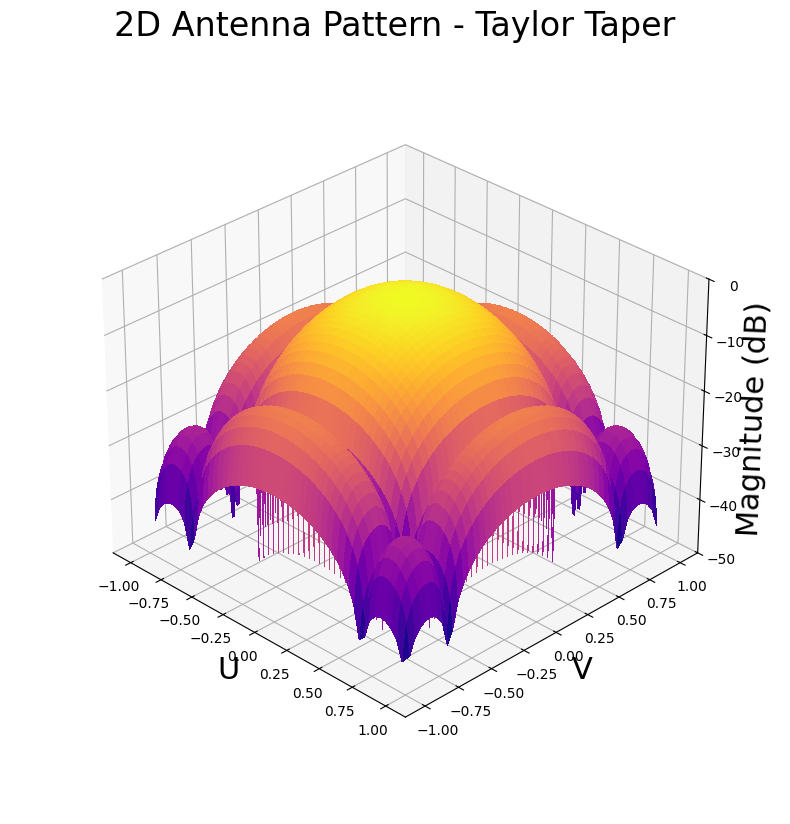

In [ ]:
%matplotlib inline

z_min = -50
z_max = 0


AF_pattern_taylor_log = 10 * np.log10(np.abs(AF_taylor))
AF_pattern_taylor_log_mask = np.where(AF_pattern_taylor_log > z_min, AF_pattern_taylor_log, np.nan)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(U, V, AF_pattern_taylor_log_mask, cmap='plasma', antialiased=False)
ax.set_zlim(z_min, z_max)
ax.set_title("2D Antenna Pattern - Taylor Taper", fontsize=24)
ax.set_xlabel("U", fontsize=22); ax.set_ylabel("V", fontsize=22); ax.set_zlabel("Magnitude (dB)", fontsize=22)
ax.view_init(elev=30, azim=-45, roll=0)
ax.set_box_aspect(None, zoom=0.85)
plt.show()

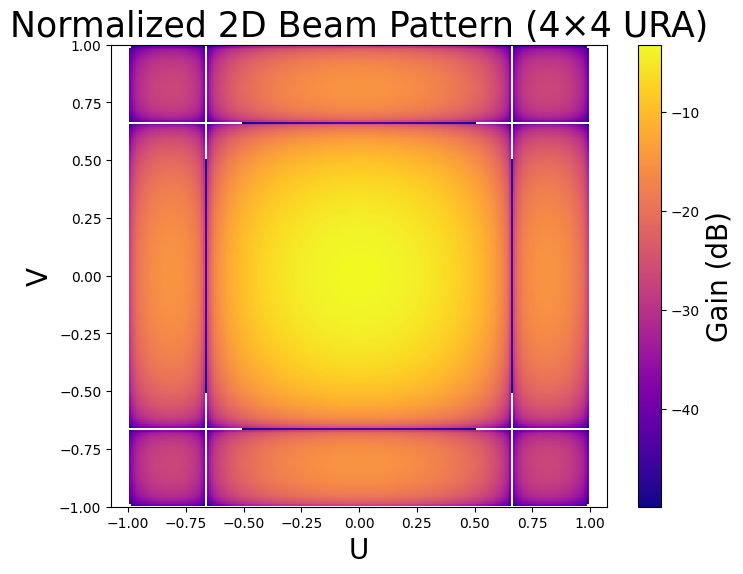

In [ ]:
# 2D Heatmap

plt.figure(figsize=(8, 6))
im = plt.pcolormesh(U, V, AF_pattern_taylor_log_mask, shading='auto', cmap='plasma')
cbar = plt.colorbar(im)
cbar.set_label('Gain (dB)', fontsize = 20)
plt.title('Normalized 2D Beam Pattern (4×4 URA)', fontsize = 25)
plt.xlabel('U', fontsize = 20); plt.ylabel('V', fontsize = 20)
plt.axis('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()

# **Section 2**: TX Beamforming Simulation

In [ ]:
# Set Steering Angles and Compute Direction-Cosine

elevation_steering_angle = 20   # up/down
azimuth_steering_angle   = 30   # left/right

u_0 = np.sin(np.deg2rad(elevation_steering_angle)) * np.cos(np.deg2rad(azimuth_steering_angle))
v_0 = np.sin(np.deg2rad(elevation_steering_angle)) * np.sin(np.deg2rad(azimuth_steering_angle))

In [ ]:
# Select amplitude tapers

w_m = weight_taylor_m.astype(float)   # length M
w_n = weight_taylor_n.astype(float)   # length N

# Create integer grid

index_m = np.arange(M)[:, None]      # rows x
index_n = np.arange(N)[None, :]      # columns y

# Compute the spatial phase each element needs to point the beam towards
#---To transmit a beam, give each element a complex weight that cancels
#   that spatial phase so all elements add in phase in that direction.

phase_shift = k * (index_m * d_y * v_0 + index_n * d_x * u_0)   # Steering phase shift (the actual delay applied to each element)
steering_weight = (w_m[:, None] * w_n[None, :]) * np.exp(-1j * phase_shift)  # complex TX weight per element (M x N)

In [ ]:
# Phase of each TX weight in degrees
phase_array_tx = np.angle(steering_weight, deg=True)

print(f"4x4 TX phase shift (degrees): for Elevation = {elevation_steering_angle}°, Azimuth = {azimuth_steering_angle}°")
print(phase_array_tx)

4x4 TX phase shift (degrees): for Elevation = 20°, Azimuth = 30°
[[   0.          -53.31566389 -106.63132778 -159.94699167]
 [ -30.7818129   -84.09747679 -137.41314068  169.27119543]
 [ -61.5636258  -114.87928969 -168.19495358  138.48938253]
 [ -92.3454387  -145.66110259  161.02323352  107.70756963]]
